# A Convolutional Autoencoder for Anomaly Detection

Anomaly detection is the task of finding anomalous data elements in a dataset. An anomaly is a data element that is an outlier with respect to the rest of the dataset.

We are going to train an autoencoder on the MNIST dataset (that only contains numbers), and then we will look into anomalies within the MNIST dataset (i.e., images within MNIST that are somehow different than the rest of the dataset).

Even though MNIST is a labeled dataset, we are going to disregard the labels for educational purposes and consider it as an unlabeled datasets.

**This time we are going to use a CNN-based auto-encoder.**

In [1]:
# !pip install -r requirements.txt | grep -v "already"

> After installing the dependencies you need to restart your kernel. The following cell does that for you.

In [1]:
# import IPython

# IPython.Application.instance().kernel.do_shutdown(True) #automatically restarts kernel

{'status': 'ok', 'restart': True}

In [1]:
import torch
import numpy as np
from torchvision import datasets
from torch import nn
import torchvision.models
import torchvision.transforms as transforms
import multiprocessing
from tqdm import tqdm
from helpers import get_data_loaders
from helpers import seed_all
from helpers import anomaly_detection_display
import pandas as pd

# Ensure repeatibility
seed_all(42)

In [2]:
# This will get data loaders for the MNIST dataset for the train, validation
# and test dataset
data_loaders = get_data_loaders(batch_size=1024)

Using 48000 examples for training and 12000 for validation
Using 10000 for testing


### Visualize the Data

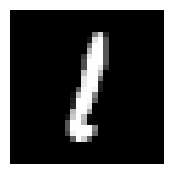

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(data_loaders['train'])
images, labels = next(dataiter)
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig, sub = plt.subplots(figsize = (2,2)) 
sub.imshow(img, cmap='gray')
_ = sub.axis("off")

---
## Convolutional Autoencoder

Write your own CNN autoencoder. Use at least 2 blocks Convolution + ReLU + MaxPooling as _encoder_, and then an equivalent number of upsampling operations (either Transposed Convolutions+ReLU or Upsample+Conv+ReLU) followed by a Sigmoid activation.

In [5]:
# define the NN architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        ## encoder ##
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2)
        )
        
        ## decoder ##
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor = 2, mode='nearest'),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Upsample(scale_factor = 2, mode='nearest'),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 1, 3, padding=1),
            nn.Sigmoid()
        )
        
        self.auto_encoder = nn.Sequential(
            self.encoder,
            self.decoder
        )

    def forward(self, x):
        # define feedforward behavior 
        # and scale the *output* layer with a sigmoid activation function
        
        return self.auto_encoder(x)
    
# initialize the NN
model = Autoencoder()

In [12]:
print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Upsample(scale_factor=2.0, mode='nearest')
    (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Upsample(scale_factor=2.0, mode='nearest')
    (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): BatchNorm2d(32, eps=1e

## Loss Function

As explained in the lesson, we can use the Mean Squared Error loss, which is called `MSELoss` in PyTorch:

In [6]:
# specify loss function
criterion = nn.MSELoss()

## Training

The training loop is similar to a normal training loop, however, this task is an unsupervised task. That means we do not need labels. The MNIST dataset does provide labels, of course, so we will just disregard them.

In [7]:
# specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-2)

In [8]:
# number of epochs to train the model
n_epochs = 50

for epoch in range(1, n_epochs + 1):
    # monitor training loss
    train_loss = 0.0
    
    if torch.cuda.is_available():
        model = model.cuda()
    
    model.train()
        
    ###################
    # train the model #
    ###################
    for data in tqdm(desc="Training", total=len(data_loaders['train']), iterable=data_loaders['train']):
        # we disregard the labels. We use the Python convention of calling
        # an unused variable "_"
        images, _ = data
        
        if torch.cuda.is_available():
            images = images.cuda()
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)

        # calculate the loss
        loss = criterion(outputs.flatten(), images.flatten())
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item() * images.size(0)
    
    # Validation
    val_loss = 0
    with torch.no_grad():
        for data in tqdm(desc="Validating", total=len(data_loaders['valid']), iterable=data_loaders['valid']):
            # _ stands in for labels, here
            images, _ = data
            
            if torch.cuda.is_available():
                images = images.cuda()

            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(images)
            # calculate the loss
            loss = criterion(outputs.flatten(), images.flatten())
            
            # update running training loss
            val_loss += loss.item() * images.size(0)
    
    # print avg training statistics
    train_loss /= len(data_loaders['train'])
    val_loss /= len(data_loaders['valid'])
    print("Epoch: {} \tTraining Loss: {:.6f}\tValid Loss: {:.6f}".format(epoch, train_loss, val_loss))

Validating: 100%|██████████| 12/12 [00:20<00:00,  1.74s/it]


Epoch: 1 	Training Loss: 77.403790	Valid Loss: 30.221082


Validating: 100%|██████████| 12/12 [00:23<00:00,  1.97s/it]


Epoch: 2 	Training Loss: 22.417205	Valid Loss: 13.275919


Validating: 100%|██████████| 12/12 [00:19<00:00,  1.61s/it]


Epoch: 3 	Training Loss: 13.150022	Valid Loss: 8.192266


Validating: 100%|██████████| 12/12 [00:22<00:00,  1.90s/it]


Epoch: 4 	Training Loss: 7.916292	Valid Loss: 7.221025


Validating: 100%|██████████| 12/12 [00:19<00:00,  1.59s/it]


Epoch: 5 	Training Loss: 6.255964	Valid Loss: 5.276323


Validating: 100%|██████████| 12/12 [00:22<00:00,  1.86s/it]


Epoch: 6 	Training Loss: 5.105857	Valid Loss: 4.968649


Validating: 100%|██████████| 12/12 [00:22<00:00,  1.87s/it]


Epoch: 7 	Training Loss: 4.904393	Valid Loss: 4.734537


Validating: 100%|██████████| 12/12 [00:22<00:00,  1.89s/it]


Epoch: 8 	Training Loss: 4.486783	Valid Loss: 4.066106


Validating: 100%|██████████| 12/12 [00:20<00:00,  1.74s/it]


Epoch: 9 	Training Loss: 3.968251	Valid Loss: 3.728353


Validating: 100%|██████████| 12/12 [00:22<00:00,  1.90s/it]


Epoch: 10 	Training Loss: 4.034767	Valid Loss: 3.434577


Validating: 100%|██████████| 12/12 [00:23<00:00,  1.92s/it]


Epoch: 11 	Training Loss: 3.465622	Valid Loss: 3.440359


Validating: 100%|██████████| 12/12 [00:21<00:00,  1.83s/it]


Epoch: 12 	Training Loss: 3.364061	Valid Loss: 3.014087


Validating: 100%|██████████| 12/12 [00:22<00:00,  1.90s/it]


Epoch: 13 	Training Loss: 3.119097	Valid Loss: 2.910136


Validating: 100%|██████████| 12/12 [00:13<00:00,  1.13s/it]


Epoch: 14 	Training Loss: 2.949037	Valid Loss: 2.754756


Validating: 100%|██████████| 12/12 [00:15<00:00,  1.29s/it]


Epoch: 15 	Training Loss: 2.885546	Valid Loss: 2.749232


Validating: 100%|██████████| 12/12 [00:13<00:00,  1.12s/it]


Epoch: 16 	Training Loss: 2.729023	Valid Loss: 2.629634


Validating: 100%|██████████| 12/12 [00:15<00:00,  1.27s/it]


Epoch: 17 	Training Loss: 2.650612	Valid Loss: 2.583685


Validating: 100%|██████████| 12/12 [00:14<00:00,  1.23s/it]


Epoch: 18 	Training Loss: 2.665064	Valid Loss: 2.444450


Validating: 100%|██████████| 12/12 [00:14<00:00,  1.18s/it]


Epoch: 19 	Training Loss: 2.569978	Valid Loss: 2.440352


Validating: 100%|██████████| 12/12 [00:14<00:00,  1.24s/it]


Epoch: 20 	Training Loss: 2.573421	Valid Loss: 2.386894


Validating: 100%|██████████| 12/12 [00:13<00:00,  1.16s/it]


Epoch: 21 	Training Loss: 2.369408	Valid Loss: 2.577930


Validating: 100%|██████████| 12/12 [00:13<00:00,  1.09s/it]


Epoch: 22 	Training Loss: 2.389388	Valid Loss: 2.224602


Validating: 100%|██████████| 12/12 [00:13<00:00,  1.10s/it]


Epoch: 23 	Training Loss: 2.317813	Valid Loss: 2.350012


Validating: 100%|██████████| 12/12 [00:16<00:00,  1.34s/it]


Epoch: 24 	Training Loss: 2.356931	Valid Loss: 2.174169


Validating: 100%|██████████| 12/12 [00:13<00:00,  1.15s/it]


Epoch: 25 	Training Loss: 2.227846	Valid Loss: 2.083175


Validating: 100%|██████████| 12/12 [00:13<00:00,  1.17s/it]


Epoch: 26 	Training Loss: 2.170409	Valid Loss: 2.033347


Validating: 100%|██████████| 12/12 [00:14<00:00,  1.22s/it]


Epoch: 27 	Training Loss: 2.200724	Valid Loss: 2.139540


Validating: 100%|██████████| 12/12 [00:13<00:00,  1.09s/it]


Epoch: 28 	Training Loss: 2.106315	Valid Loss: 2.051091


Validating: 100%|██████████| 12/12 [00:15<00:00,  1.28s/it]


Epoch: 29 	Training Loss: 2.075887	Valid Loss: 2.036195


Validating: 100%|██████████| 12/12 [00:13<00:00,  1.16s/it]


Epoch: 30 	Training Loss: 2.067306	Valid Loss: 2.019439


Validating: 100%|██████████| 12/12 [00:13<00:00,  1.12s/it]


Epoch: 31 	Training Loss: 2.058362	Valid Loss: 1.932152


Validating: 100%|██████████| 12/12 [00:13<00:00,  1.14s/it]


Epoch: 32 	Training Loss: 2.046434	Valid Loss: 1.896869


Validating: 100%|██████████| 12/12 [00:12<00:00,  1.05s/it]


Epoch: 33 	Training Loss: 1.964458	Valid Loss: 1.882025


Validating: 100%|██████████| 12/12 [00:13<00:00,  1.11s/it]


Epoch: 34 	Training Loss: 1.974933	Valid Loss: 1.979595


Validating: 100%|██████████| 12/12 [00:14<00:00,  1.21s/it]


Epoch: 35 	Training Loss: 1.948509	Valid Loss: 1.907238


Validating: 100%|██████████| 12/12 [00:14<00:00,  1.23s/it]


Epoch: 36 	Training Loss: 1.910220	Valid Loss: 1.901783


Validating: 100%|██████████| 12/12 [00:13<00:00,  1.09s/it]


Epoch: 37 	Training Loss: 1.923728	Valid Loss: 1.893518


Validating: 100%|██████████| 12/12 [00:13<00:00,  1.11s/it]


Epoch: 38 	Training Loss: 1.929604	Valid Loss: 1.817203


Validating: 100%|██████████| 12/12 [00:14<00:00,  1.18s/it]


Epoch: 39 	Training Loss: 1.849833	Valid Loss: 1.768673


Validating: 100%|██████████| 12/12 [00:13<00:00,  1.16s/it]


Epoch: 40 	Training Loss: 1.845647	Valid Loss: 1.827656


Validating: 100%|██████████| 12/12 [00:13<00:00,  1.10s/it]


Epoch: 41 	Training Loss: 1.880147	Valid Loss: 1.752144


Validating: 100%|██████████| 12/12 [00:13<00:00,  1.14s/it]


Epoch: 42 	Training Loss: 1.800158	Valid Loss: 1.727420


Validating: 100%|██████████| 12/12 [00:13<00:00,  1.15s/it]


Epoch: 43 	Training Loss: 1.783249	Valid Loss: 1.722928


Validating: 100%|██████████| 12/12 [00:13<00:00,  1.13s/it]


Epoch: 44 	Training Loss: 1.838666	Valid Loss: 1.703140


Validating: 100%|██████████| 12/12 [00:13<00:00,  1.10s/it]


Epoch: 45 	Training Loss: 1.792640	Valid Loss: 1.869545


Validating: 100%|██████████| 12/12 [00:14<00:00,  1.23s/it]


Epoch: 46 	Training Loss: 1.793891	Valid Loss: 1.712727


Validating: 100%|██████████| 12/12 [00:13<00:00,  1.13s/it]


Epoch: 47 	Training Loss: 1.711291	Valid Loss: 1.728864


Validating: 100%|██████████| 12/12 [00:13<00:00,  1.11s/it]


Epoch: 48 	Training Loss: 1.719206	Valid Loss: 1.630665


Validating: 100%|██████████| 12/12 [00:13<00:00,  1.13s/it]


Epoch: 49 	Training Loss: 1.689795	Valid Loss: 1.635187


Validating: 100%|██████████| 12/12 [00:12<00:00,  1.08s/it]

Epoch: 50 	Training Loss: 1.767251	Valid Loss: 1.691510


In [9]:
# Epoch: 50 	Training Loss: 1.359510	Valid Loss: 1.399772

## Finding anomalies
Now that our auto-encoder is trained we can use it to find anomalies. Let's consider the test set. We loop over all the batches in the test set and we record the value of the loss for each example separately. The examples with the highest reconstruction loss are our anomalies. 

Indeed, if the reconstruction loss is high, that means that our trained auto-encoder could not reconstruct them well. Indeed, what the autoencoder learned about our dataset during training is not enough to describe these examples, which means they are different than what the encoder has seen during training, i.e., they are anomalies (or at least they are the most uncharacteristic examples).

Let's have a look:

In [10]:
# Since this dataset is small we collect all the losses as well as
# the image and its reconstruction in a dictionary. In case of a
# larger dataset you might have to save on disk
# (won't fit in memory)
losses = {}

# We need the loss by example (not by batch)
loss_no_reduction = nn.MSELoss(reduction='none')

idx = 0

with torch.no_grad():
    for data in tqdm(desc="Testing", total=len(data_loaders['test']),
            iterable=data_loaders['test']
        ):

            images, labels = data
            
            if torch.cuda.is_available():
                images = images.cuda()
                        
            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(images)
            
            # calculate the loss
            loss = loss_no_reduction(outputs, images)
            
            # Accumulate results per-example
            for i, l in enumerate(loss.mean(dim=[1, 2, 3])):
                losses[idx + i] = {
                    'loss': float(l.cpu().numpy()),
                    'image': images[i].cpu().numpy(),
                    'reconstructed': outputs[i].cpu().numpy()
                }
            
            idx += loss.shape[0]

# Let's save our results in a pandas DataFrame
df = pd.DataFrame(losses).T
df.head()

Testing: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


,loss,image,reconstructed
0,0.000841,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.006820401, 0.0010048662, 0.0010437146, 0...."
1,0.001485,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.007986037, 0.0012274875, 0.0012194489, 0...."
2,0.000414,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0065561417, 0.0009968043, 0.001051646, 0...."
3,0.001811,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.006611837, 0.0010057829, 0.0010679308, 0...."
4,0.00097,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.006649186, 0.0010249058, 0.0011541948, 0...."


Let's now display the histogram of the loss. The elements on the right (with the higher loss) are the most uncharacteristic examples. Feel free to look into `helpers.py` to see how these plots are made:

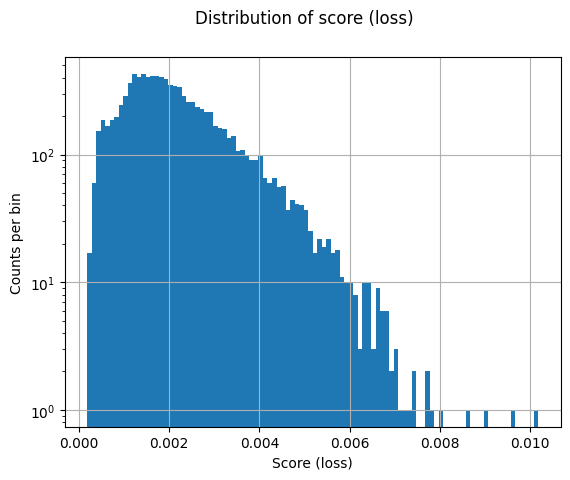

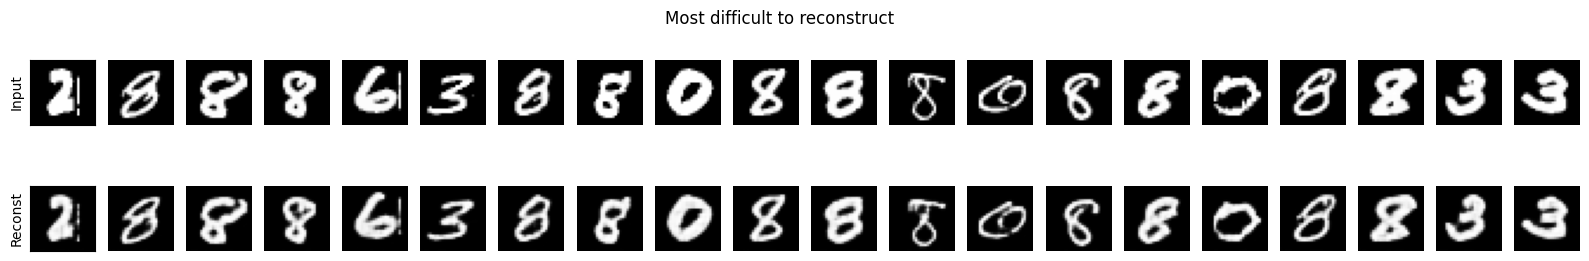

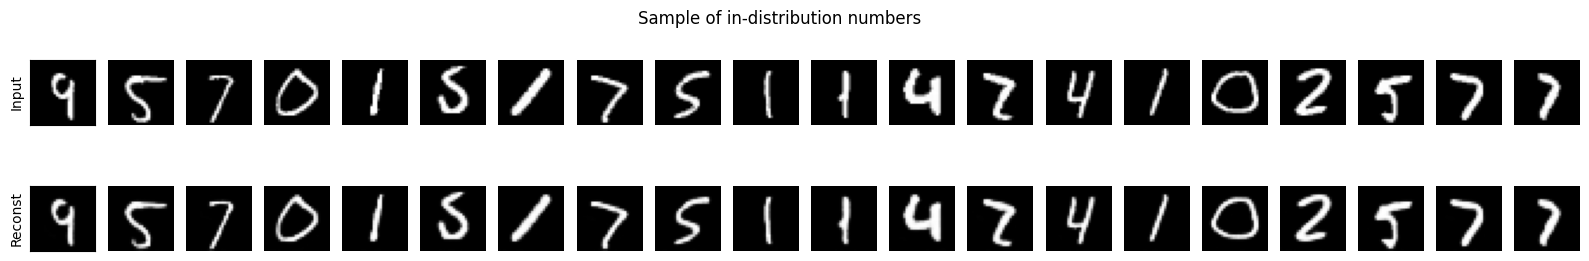

In [11]:
from helpers import anomaly_detection_display

anomaly_detection_display(df)

We got similar results as in the case of linear auto-encoders, but the loss is on average much smaller (a sign that the network is much more capable of representing and reconstructing the dataset).